# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 14.03.22
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github/collab или public kaggle notebook.
3. Необходимо получить на Public Leaderboard R2 > 0.71. (Для оценки отлично нужно пробить скорр baseline на LAMA - Public > 0.75000)
4. Укажите свой ник на kaggle **обязательно** 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять **только лучшую модель**, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

https://www.kaggle.com/c/real-estate-price-prediction-moscow/data

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
matplotlib.rcParams.update({'font.size': 14})

### Функция для отрисовки

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

путь к трейну и к тесту

In [7]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/GB/Python_libs/10. Вебинар 5 Консультация по проекту/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/GB/Python_libs/10. Вебинар 5 Консультация по проекту/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

Priceу нас есть датасет. есть индентификаторы по нашей недвижимости: Id, DistrictId, Rooms  ... Shops_1, Shops_2 , Price. 

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


посчитаем сколько строк в трейне и в тесте. 

In [11]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

Работаем с пропусками и выбросами, аномалиями в данных. Генерция новых фичей. 

**Целевая переменная**

график распределения целевой переменной

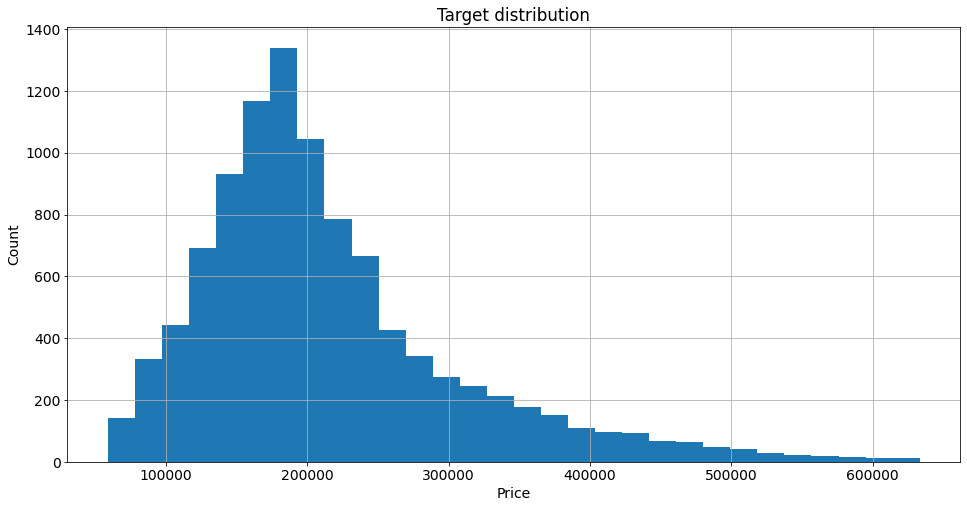

In [15]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

Метод дискрайб, смотрим наши статистики

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

работа со столбцами, которые имеют строковые типы данных. Анализируем какие данные у нас в каких столбцах, как можем классифицировать данные. 

In [17]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

смотрим какие данные имеет дистрикт ай ди. 

In [18]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

смотрим какие данные в экологии. видим всего 2 типа данных: А и В

In [19]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [21]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

Работаем с выбросами. 

**Rooms**

In [22]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

введём новый столбец Rooms_outlier . Это выброс признак 1 или 0. Мы можем данные выбросы заполнить, если количество комнат = 0 заполнить 1, если количество комнат больше 6 заполнить медианой. Признак выброса мы пометили. 

In [23]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [24]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [25]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

Посмотрим на квантили 'KitchenSquare' 97.5% квантиль ограничен 13 и 2.5% квантиль ограничен нулём. т.е у нас есть нули - редкое значение. Запишем что если у нас  'KitchenSquare' пустое или больше 13 т.е больше  97.5% квантиля, то мы поставим медиану. Если 'KitchenSquare' меньше 3, то забъем значением 3. 

In [27]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [28]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [29]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

количество этажей во всём доме

In [30]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

количество этажей на котором находится квартира

In [31]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

у нас есть 1825 наблюдений, где текущий этаж квартиры больше чем всего этажей в доме. Соответственно помечаем такие наблюдения, что это выброс train_df['HouseFloor_outlier'] = 0. Если [train_df['HouseFloor'] == 0 приравняем его к 1. если train_df.loc[train_df['Floor'] > train_df['HouseFloor'] этаж квартиры  больше чем этажей в доме также приравняем к 1

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [33]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Если количество этажей в доме равно 0, заполним такие значения медианой

In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

в случае если этаж больше дома. таких у нас 1600, видимо потому что HouseFloor был равен 0 мы выбирем рандомно от 1 до х. lambda x: random.randint(1, x), где х это HouseFloor. Если этаж квартиры больше чем этажность дома мы рандомно проставляем этаж от 1 до этажности дома. 

In [35]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [36]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

смотрим, что таких некорректных данных больше неосталось

In [37]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

Если год постройки больше чем текущая дата, мы заменяем год постройки на текущий год. 

In [38]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [39]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [47]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

In [41]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare**

Если у нас имеется где то пропуск в LifeSquare, Square, KitchenSquare мы такие значения заполняем следующим образом. train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

In [43]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [ ]:
# предлагаю самим поработать с ним
train_df.drop('Healthcare_1', axis=1, inplace=True)

оформляем класс DataPreprocessing, где инициализируем медианы, kitchen_square_quantile и методы fit и transform делают все преобразования. 

In [49]:
# критерий для "отлично" - оформление по принципу ООП классов для предобработки данных
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

делаем дамми переменные. 

In [50]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

делаем бинаризацию переменной

In [51]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [54]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,89


In [55]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [56]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [57]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [58]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,89,0,201584.441255


**MedPriceByFloorYear**

In [59]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [60]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [61]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [62]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,89,0,201584.441255,3,5


In [63]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,377289.553272
1,1,2,321506.277104
2,1,3,429090.881284
3,1,4,274992.472366
4,2,1,467230.539057


In [64]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,851,1,213530.788443,6,2,166359.393226
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,78,0,146032.829834,3,3,192048.442631
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,652,1,244005.272380,4,1,203358.120017
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,652,1,146735.671740,3,4,183494.399043
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,89,0,201584.441255,3,5,173934.865013


In [65]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

смотрим какие у нас признаки получились после генирации новых фичей. 

In [66]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

теперь у нас есть фичи, новые фичи и имя таргет переменной.

In [67]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

Экспортируем трейн и тест датасеты, в трейне делаем датасет Х и дропаем (удаляем столбец) таргет. Этот таргет передаём в Y и теперь у нас есть Х и У

In [68]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

для валидации мы **выделяем 33% под Тест на датасете Train**. Датасет test - только для предсказаний для отправки на kaggle

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [71]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

# мы имеем 3 множества: обучающее, валидационное (для валидации - содержит target) и тестовое (для kaggle - оно без target)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [72]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

# мы применяем EDA (выбросы, пропуски, новые фичи) ко всем 3м датасетам!!!
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [74]:
len(new_feature_names)

9

In [75]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [76]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

In [ ]:
!pip install lightautoml

**Обучение**

In [78]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

**Оценка модели**

Train R2:	0.966
Test R2:	0.708


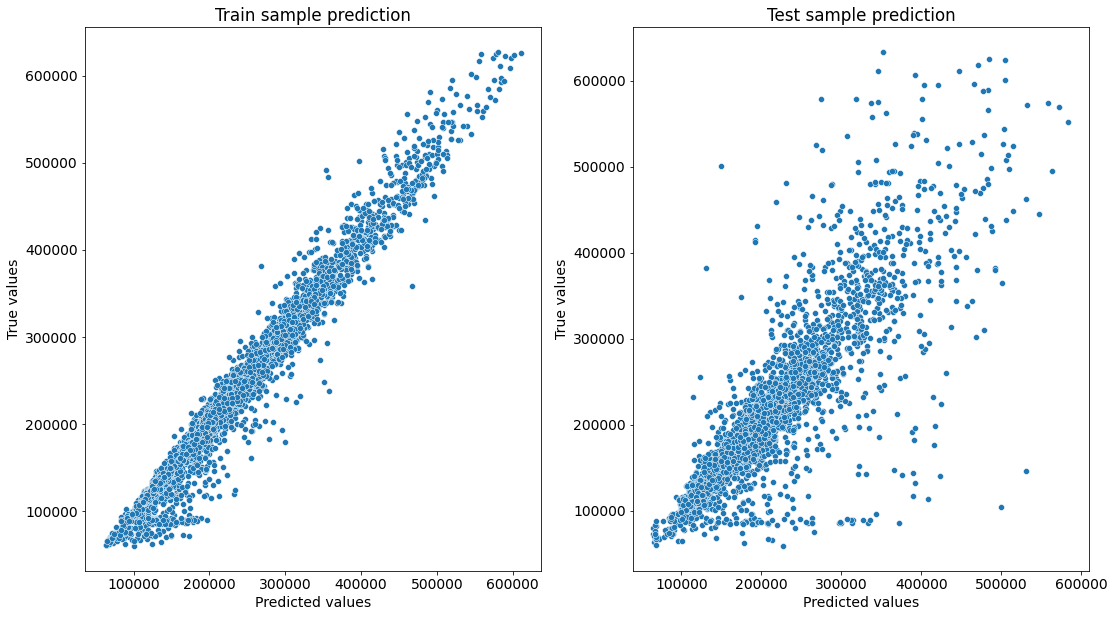

In [79]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [ ]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.77137539, 0.72838201, 0.75313253])

In [ ]:
cv_score.mean()

0.7509633072547972

**Важность признаков**

In [80]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,6.500677e-01
1,Square,1.086190e-01
2,LifeSquare,3.405290e-02
6,HouseYear,2.268132e-02
5,HouseFloor,2.237468e-02
20,DistrictSize,2.048922e-02
24,MedPriceByFloorYear,2.022471e-02
12,Social_3,2.006032e-02
4,Floor,1.642251e-02
3,KitchenSquare,1.561358e-02


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [ ]:
test_df.shape

(5000, 25)

In [81]:
submit = pd.read_csv('/content/drive/My Drive/GB/Python_libs/10. Вебинар 5 Консультация по проекту/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [82]:
predictions = rf_model.predict(test_df)
predictions

array([159119.5145019 , 121725.93731055, 137755.63876094, ...,
       149343.22716521, 188902.11436345, 227197.16373881])

In [83]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159119.514502
1,5925,121725.937311
2,960,137755.638761
3,3848,166115.412472
4,746,179328.771261


In [84]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,0,0,0,76.0,0,0,171145.169069,188641.370170
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,0,0,0,164.0,0,1,131107.271962,179449.269388
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,0,0,1,580.0,0,1,165993.292450,174513.628600
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,0,0,0,372.0,0,1,172778.615365,179689.517526
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,0,0,1,65.0,0,0,164116.183543,192048.442631


In [85]:
submit.to_csv('rf_submit.csv', index=False)

### Light auto ML

https://lightautoml.readthedocs.io/en/latest/

https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html

In [90]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error, rmsle, r2_score

In [108]:
TARGET_NAME = target_name

In [109]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)


preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

X_train = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)


features_gen = FeatureGenetator()
features_gen.fit(X_train, X_train[TARGET_NAME])

X_train = features_gen.transform(X_train)
test_df = features_gen.transform(test_df)

In [110]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,0,0,0,104.0,0,1,1.0,2,171145.169069,188548.566384
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,0,0,0,247.0,0,1,2.0,5,129107.218932,171909.534948
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,0,0,1,851.0,0,1,4.0,2,165683.084779,171931.149112
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,0,0,0,565.0,0,1,0.0,2,166687.735824,180420.595628
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,0,0,1,114.0,0,1,2.0,2,165071.825722,190891.093552


In [111]:
TASK = Task('reg', loss='mse', metric=rmsle, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'Price'
TEST_SIZE=0.2

In [112]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [113]:
automl_model = TabularAutoML(task=TASK,
                            timeout=TIMEOUT,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params={'use_algos': [ ['lgb_tuned', 'cb_tuned', 'cb'], ['lgb_tuned', 'cb'] ]},
                            tuning_params={'max_tuning_iter': 10},
                      )

Почитайте какую архитектуру лучше использовать https://lightautoml.readthedocs.io/_/downloads/en/docs-contributing_guide/pdf/

In [114]:
oof_pred = automl_model.fit_predict(X_train, roles = roles)

In [115]:
test_df['Price'] = automl_model.predict(test_df).data

In [116]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Price
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0,0,0,0,104.0,0,1,1.0,2,171145.169069,188548.566384,211620.875000
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0,0,0,0,247.0,0,1,2.0,5,129107.218932,171909.534948,212487.078125
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,0,0,0,1,851.0,0,1,4.0,2,165683.084779,171931.149112,213136.890625
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0,0,0,0,565.0,0,1,0.0,2,166687.735824,180420.595628,213134.406250
4,746,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,0,0,0,1,114.0,0,1,2.0,2,165071.825722,190891.093552,216807.640625


In [117]:
test_df.to_csv('submission_LAMA.csv', columns=['Id', 'Price'], index=False)